In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/gdrive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

100% 657M/658M [00:36<00:00, 20.4MB/s]
100% 658M/658M [00:36<00:00, 19.0MB/s]


In [ ]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

# new

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
os.listdir('/content/plantvillage/PlantVillage')

['Tomato__Tomato_mosaic_virus',
 'Tomato__Target_Spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___healthy',
 'Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Early_blight',
 'Potato___Early_blight',
 'Tomato_Late_blight',
 'Pepper__bell___Bacterial_spot',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Pepper__bell___healthy']

In [ ]:
list_diseases = os.listdir('/content/plantvillage/PlantVillage')

In [ ]:
len(list_diseases)

15

In [ ]:
len(os.listdir('/content/plantvillage/PlantVillage/Potato___healthy'))

152

In [ ]:
results2 = []
for disease in list_diseases:
    dies_name_count = {}
    count_disease = len(os.listdir(f'/content/plantvillage/PlantVillage/{disease}'))
    dies_name_count['disease'] = disease
    dies_name_count['count_images'] = count_disease
    results2.append(dies_name_count)

In [ ]:
results = pd.DataFrame(results2)
results

,disease,count_images
0,Tomato__Tomato_mosaic_virus,373
1,Tomato__Target_Spot,1404
2,Tomato_Spider_mites_Two_spotted_spider_mite,1676
3,Potato___healthy,152
4,Tomato_healthy,1591
5,Tomato__Tomato_YellowLeaf__Curl_Virus,3209
6,Tomato_Bacterial_spot,2127
7,Tomato_Septoria_leaf_spot,1771
8,Tomato_Early_blight,1000
9,Potato___Early_blight,1000


In [ ]:
# bar plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

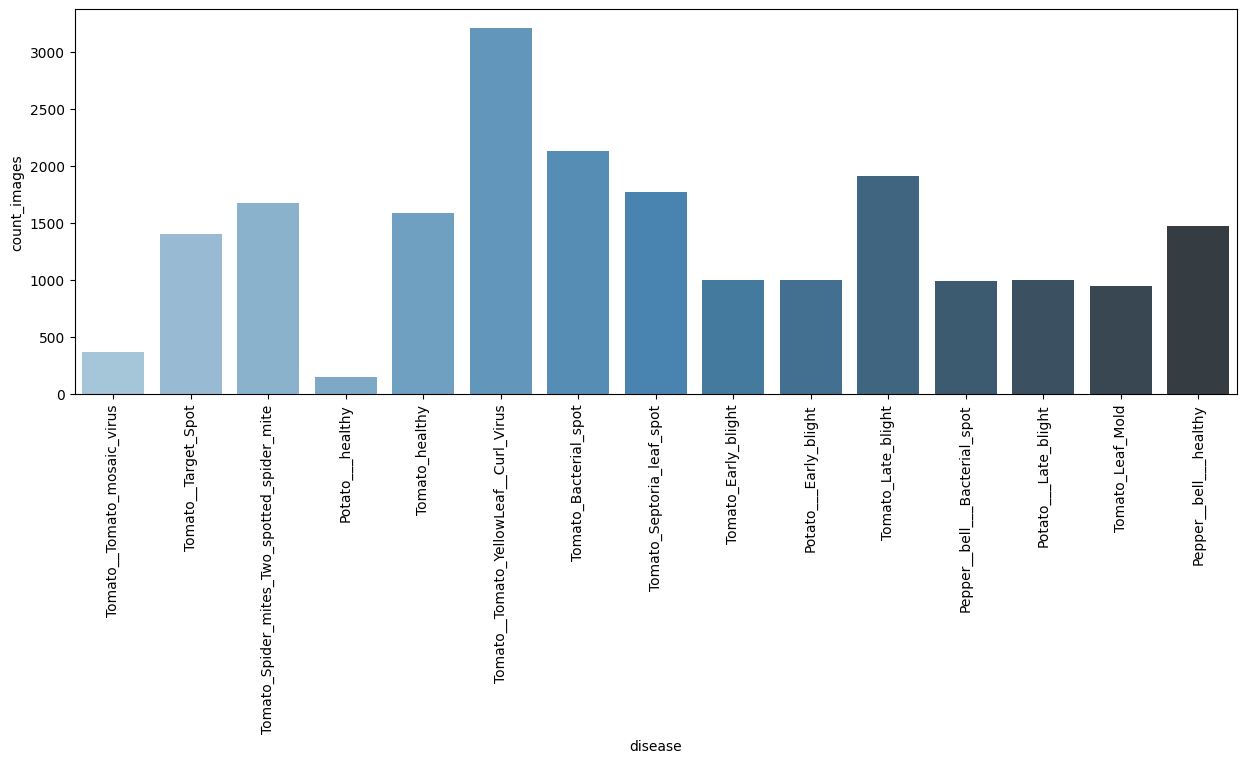

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='disease', y = 'count_images', data= results, palette='Blues_d')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# need to add each category count
tomato_diseases, pepper_diseases, potato_diseases = [], [],[]
for disease in list_diseases:
    if 'Tomato' in disease:
        tomato_diseases.append(disease)
    if 'Pepper' in disease:
        pepper_diseases.append(disease)
    if 'Potato' in disease:
        potato_diseases.append(disease)

In [ ]:
total_t_count = 0
for t_d in tomato_diseases:
    t_disease_count = len(os.listdir(f'/content/plantvillage/PlantVillage/{t_d}'))
    total_t_count += t_disease_count

In [ ]:
total_t_count

16012

In [ ]:
total_p_count = 0
for t_p in pepper_diseases:
    p_disease_count = len(os.listdir(f'/content/plantvillage/PlantVillage/{t_p}'))
    total_p_count += p_disease_count
# total pepper Count
total_p_count

2475

In [ ]:
total_po_count = 0
for t_po in potato_diseases:
    po_disease_count = len(os.listdir(f'/content/plantvillage/PlantVillage/{t_po}'))
    total_po_count += po_disease_count
# total potato Count
total_po_count

2152

In [ ]:
ind_count = pd.DataFrame([{'Category':'Pepper','Count':total_p_count},
{'Category':'Potato','Count':total_po_count},
{'Category':'Tomato','Count':total_t_count}])

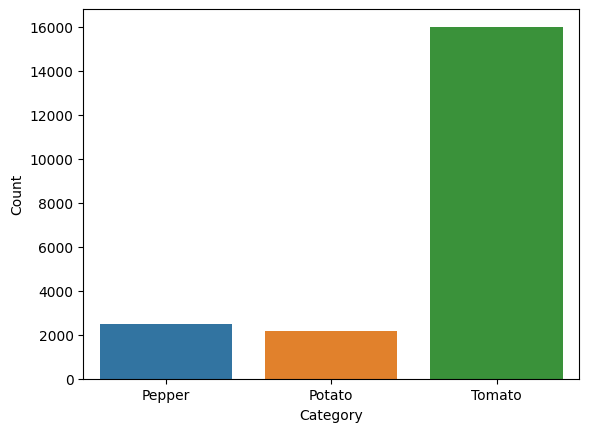

In [ ]:
sns.barplot(x='Category', y = 'Count', data=ind_count)
plt.show()

In [ ]:
root = '/content/plantvillage/PlantVillage/'

In [ ]:
os.listdir(root+'Tomato_Leaf_Mold')[100]


'206234e4-72f0-4543-8945-a697ceffe3c9___Crnl_L.Mold 6795.JPG'

In [ ]:
from PIL import Image
fol_path = root
cat_list = []
images_list = []
for t_c in tomato_diseases:
    dir_path = os.path.join(fol_path, t_c)
    img_path = os.listdir(dir_path)[0]
    cat_list.append(t_c)
    images_list.append(os.path.join(fol_path, t_c,img_path))

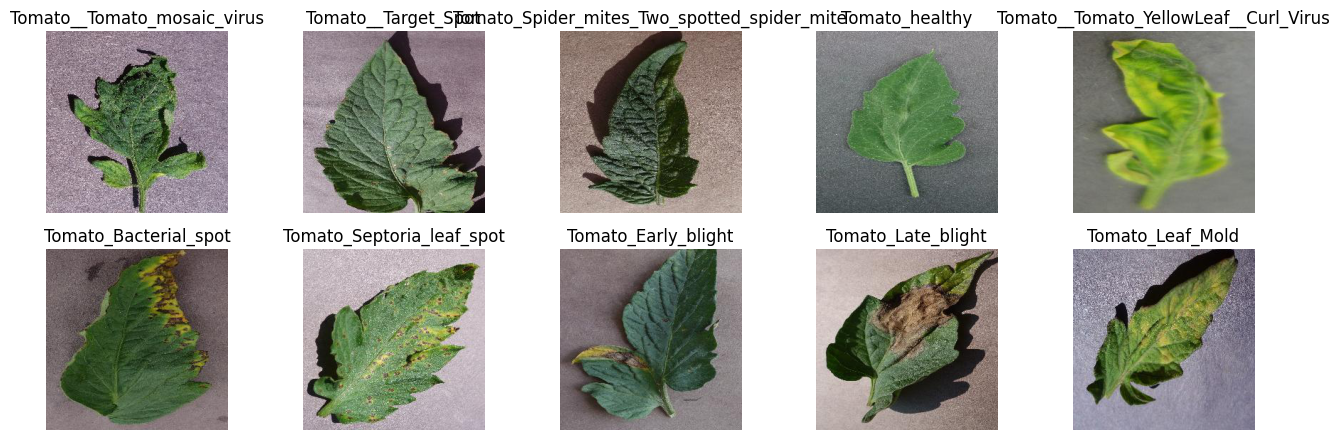

In [ ]:
rows = 3
plt.figure(figsize=(16, 8)) 
for i,name in enumerate(cat_list):
    img = Image.open(images_list[i])
    plt.subplot(rows,5,i+1)
    plt.title(cat_list[i])
    plt.axis('off')
    plt.imshow(img)

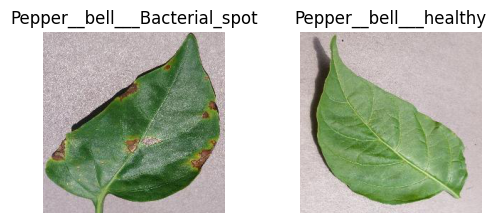

In [ ]:
p_cat_list = []
p_images_list = []
for t_p in pepper_diseases:
    dir_path = os.path.join(fol_path, t_p)
    img_path = os.listdir(dir_path)[0]
    p_cat_list.append(t_p)
    p_images_list.append(os.path.join(fol_path, t_p,img_path))
    
rows = 3
plt.figure(figsize=(16, 8)) 
for i,name in enumerate(p_cat_list):
    img = Image.open(p_images_list[i])
    plt.subplot(rows,5,i+1)
    plt.title(p_cat_list[i])
    plt.axis('off')
    plt.imshow(img)

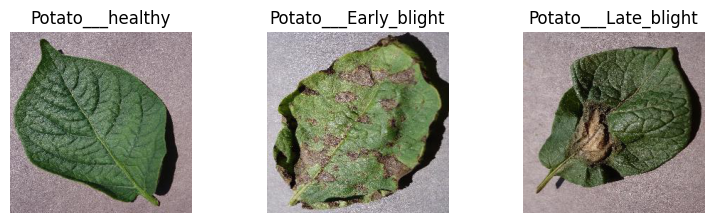

In [ ]:
po_cat_list = []
po_images_list = []
for t_po in potato_diseases:
    dir_path = os.path.join(fol_path, t_po)
    img_path = os.listdir(dir_path)[0]
    po_cat_list.append(t_po)
    po_images_list.append(os.path.join(fol_path, t_po,img_path))
    
rows = 3
plt.figure(figsize=(16, 8)) 
for i,name in enumerate(po_cat_list):
    img = Image.open(po_images_list[i])
    plt.subplot(rows,5,i+1)
    plt.title(po_cat_list[i])
    plt.axis('off')
    plt.imshow(img)

In [ ]:
labels = list(os.listdir(root))

In [ ]:
labels

['Tomato__Tomato_mosaic_virus',
 'Tomato__Target_Spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___healthy',
 'Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Early_blight',
 'Potato___Early_blight',
 'Tomato_Late_blight',
 'Pepper__bell___Bacterial_spot',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Pepper__bell___healthy']

In [ ]:
im_sh = Image.open(root + '/Tomato_Leaf_Mold/00694db7-3327-45e0-b4da-a8bb7ab6a4b7___Crnl_L.Mold 6923.JPG')

In [ ]:
h,w = im_sh.size
print(h, w)

256 256


In [ ]:
fol_path


'/content/plantvillage/PlantVillage/'

In [ ]:
os.listdir(fol_path)

['Tomato__Tomato_mosaic_virus',
 'Tomato__Target_Spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___healthy',
 'Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Early_blight',
 'Potato___Early_blight',
 'Tomato_Late_blight',
 'Pepper__bell___Bacterial_spot',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Pepper__bell___healthy']

In [ ]:
IMG_SIZE = 64
import cv2
training = []
for lb in labels:
    img_path = os.path.join(fol_path, lb)
    class_num = labels.index(lb)
    for img in os.listdir(img_path):
        try:
            img_array = cv2.imread(os.path.join(img_path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])
        except:
            continue

In [ ]:
X, y = [], []
for features, label in training:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X = X.astype('float32')
X /= 255
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 15)
print(Y[100])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
Y[20000]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0,shuffle=True)

In [ ]:
X_train.shape

(16510, 64, 64, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape=(64,64,3)),
    MaxPooling2D((2,2),strides=2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2),strides=2),
    Flatten(),
    Dense(64,activation='relu'),
    Dense(15, activation='softmax')
    
])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                2

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.85):
            print("ur reached 90% accuracy")
            self.model.stop_training = True

In [ ]:
callbacks = myCallBack()


In [ ]:
history = model.fit(X_train, y_train, batch_size= 16, epochs=20, verbose=1, validation_data=(X_test, y_test),callbacks=[callbacks])

Epoch 1/20
1032/1032 [==============================] - 17s 6ms/step - loss: 1.3311 - accuracy: 0.5724 - val_loss: 0.9145 - val_accuracy: 0.7008
Epoch 2/20
1032/1032 [==============================] - 5s 5ms/step - loss: 0.7378 - accuracy: 0.7555 - val_loss: 0.6739 - val_accuracy: 0.7781
Epoch 3/20
1032/1032 [==============================] - 5s 5ms/step - loss: 0.5536 - accuracy: 0.8135 - val_loss: 0.5601 - val_accuracy: 0.8081
Epoch 4/20
1032/1032 [==============================] - 6s 6ms/step - loss: 0.4687 - accuracy: 0.8419 - val_loss: 0.5894 - val_accuracy: 0.8028
Epoch 5/20
1032/1032 [==============================] - 5s 5ms/step - loss: 0.3791 - accuracy: 0.8731 - val_loss: 0.5335 - val_accuracy: 0.8251
Epoch 6/20
1032/1032 [==============================] - 6s 6ms/step - loss: 0.3193 - accuracy: 0.8937 - val_loss: 0.4923 - val_accuracy: 0.8442
Epoch 7/20
1032/1032 [==============================] - 5s 5ms/step - loss: 0.2859 - accuracy: 0.9040 - val_loss: 0.4882 - val_accuracy

In [ ]:
model.save('./plant_dieases_v1')

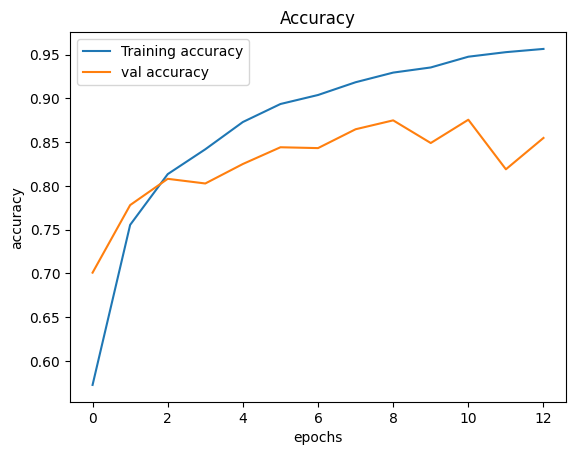

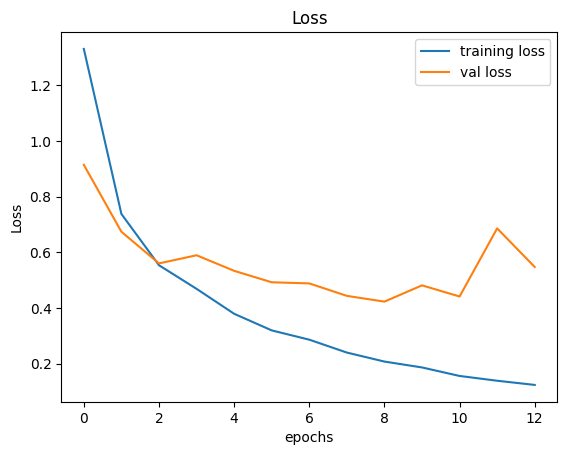

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

129/129 [==============================] - 1s 4ms/step - loss: 0.5472 - accuracy: 0.8549
Test Score:  0.5471706390380859
Test accuracy:  0.8548933863639832


In [ ]:
preds = np.round(model.predict(X_test),0)
print('Rounded test labels',preds)

129/129 [==============================] - 0s 2ms/step
Rounded test labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
y_test


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import classification_report

# predict 
pred = model.predict(X_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
# label
y_target = np.argmax(y_test, axis=1)
y_target

129/129 [==============================] - 0s 2ms/step


array([10,  6, 14, ...,  2,  1,  4])

In [ ]:
print(classification_report(y_target, pred, target_names = labels))

                                             precision    recall  f1-score   support

                Tomato__Tomato_mosaic_virus       0.83      0.85      0.84        74
                        Tomato__Target_Spot       0.67      0.93      0.78       282
Tomato_Spider_mites_Two_spotted_spider_mite       0.91      0.84      0.88       332
                           Potato___healthy       0.87      0.65      0.74        31
                             Tomato_healthy       0.96      0.96      0.96       303
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.95      0.96      0.96       676
                      Tomato_Bacterial_spot       0.96      0.94      0.95       410
                  Tomato_Septoria_leaf_spot       0.88      0.67      0.76       342
                        Tomato_Early_blight       0.79      0.44      0.56       225
                      Potato___Early_blight       0.88      0.94      0.91       195
                         Tomato_Late_blight       0.69      0.88

In [ ]:
model.predict(X_test)[1]

129/129 [==============================] - 0s 3ms/step


array([1.1532942e-11, 5.8300175e-02, 5.4619402e-05, 2.9386117e-06,
       3.0490432e-05, 6.0990341e-03, 8.8836241e-01, 7.4860527e-06,
       5.2155587e-03, 6.9228942e-11, 8.5742970e-04, 1.6424550e-06,
       4.1061342e-02, 6.8214604e-06, 4.9669482e-09], dtype=float32)

In [ ]:
from tensorflow import keras
test_img_path = root + '/Tomato_Spider_mites_Two_spotted_spider_mite/00fa99e8-2605-4d72-be69-98277587d84b___Com.G_SpM_FL 1453.JPG'
img = keras.preprocessing.image.load_img(
    test_img_path, target_size=(64, 64)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 142ms/step
This image most likely belongs to Tomato__Target_Spot with a 16.26 percent confidence.
